## Signal Generation Basics

This example demonstrates the fundamentals of digital signal generation:
- Creating binary sequences (PRBS)
- Mapping bits to symbols
- Generating OOK (On-Off Keying) waveforms
- Understanding samples per symbol (sps)
- Visualizing signals in time and frequency domains

Learning objectives:
- Understand the relationship between symbol rate, sampling rate, and sps
- Learn how digital information is represented as analog waveforms
- Explore the spectral characteristics of different pulse shapes

EXAMPLE 01: Signal Generation Basics

[Step 1] Generating Binary Data
----------------------------------------------------------------------
Generated 100000 bits using PRBS-7
First 20 bits: [0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1]
Bit statistics: 66665 ones, 33335 zeros

[Step 2] Understanding Sampling Parameters
----------------------------------------------------------------------
Symbol rate: 20000.0 kHz
Sampling rate: 100000.0 kHz
Samples per symbol (sps): 5

This means each symbol is represented by 5 samples
Total signal duration: 5.00 ms

[Step 3] Generating Signals with Different Pulse Shapes
----------------------------------------------------------------------
✓ Impulse signal: 500000 samples
✓ Boxcar signal: 500000 samples
✓ Gaussian signal: 500000 samples
✓ RRC signal: 500000 samples

[Step 4] Visualizing Time Domain Signals
----------------------------------------------------------------------


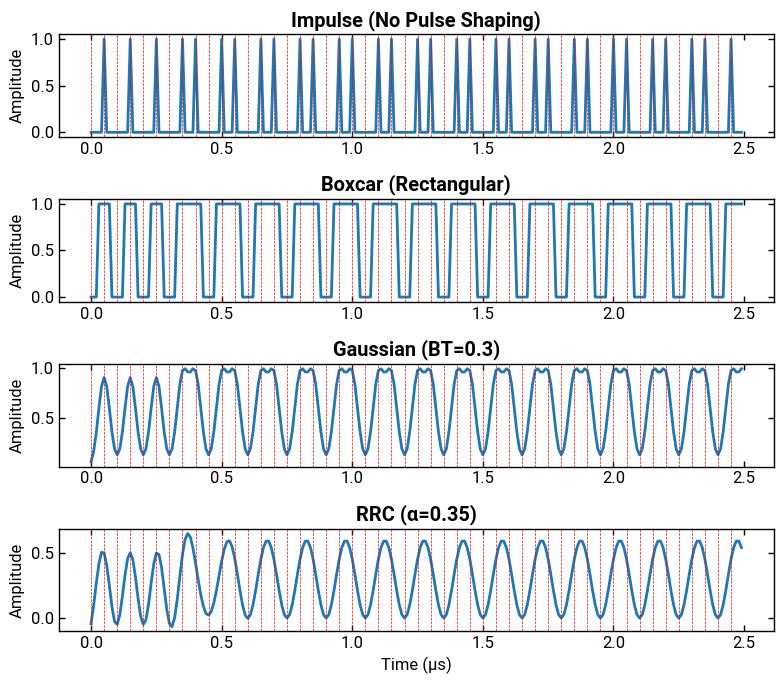


[Step 5] Visualizing Frequency Domain (PSD)
----------------------------------------------------------------------


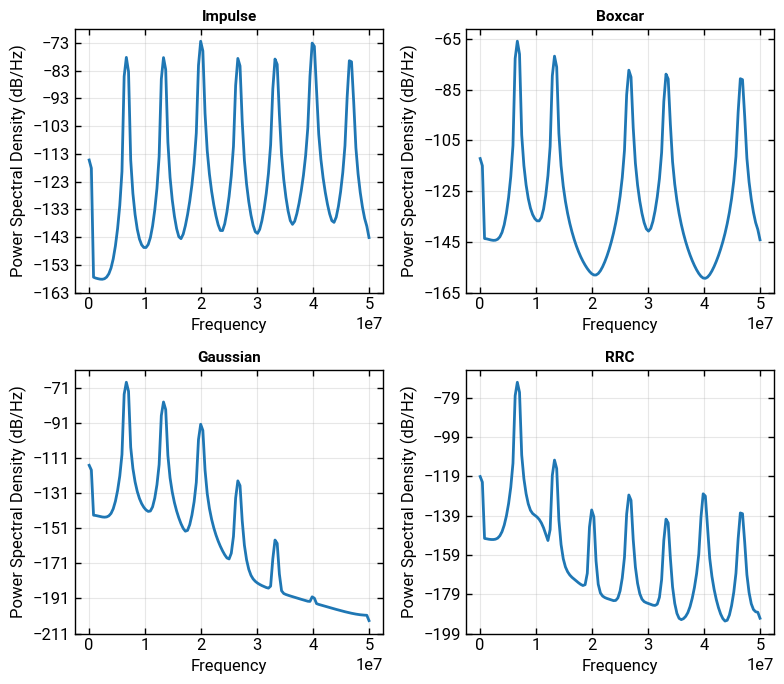

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from commstools import set_backend, Signal
from commstools.dsp.sequences import prbs
from commstools.waveforms import ook

# Use NumPy backend for this example
set_backend("numpy")

print("=" * 70)
print("EXAMPLE 01: Signal Generation Basics")
print("=" * 70)

# =============================================================================
# Step 1: Generate Binary Data
# =============================================================================
print("\n[Step 1] Generating Binary Data")
print("-" * 70)

# Generate a Pseudo-Random Binary Sequence (PRBS)
# PRBS-7 has a period of 2^7 - 1 = 127 bits
bits = prbs(length=100000, order=7, seed=42)

print(f"Generated {len(bits)} bits using PRBS-7")
print(f"First 20 bits: {bits[:20]}")
print(f"Bit statistics: {np.sum(bits)} ones, {len(bits) - np.sum(bits)} zeros")

# =============================================================================
# Step 2: Understanding Sampling Parameters
# =============================================================================
print("\n[Step 2] Understanding Sampling Parameters")
print("-" * 70)

# Define system parameters
symbol_rate = 20e6  # 10 kHz symbol rate (10,000 symbols per second)
sampling_rate = 100e6  # 100 kHz sampling rate (100,000 samples per second)
sps = int(sampling_rate / symbol_rate)  # Samples per symbol

print(f"Symbol rate: {symbol_rate / 1e3:.1f} kHz")
print(f"Sampling rate: {sampling_rate / 1e3:.1f} kHz")
print(f"Samples per symbol (sps): {sps}")
print(f"\nThis means each symbol is represented by {sps} samples")
print(f"Total signal duration: {len(bits) / symbol_rate * 1000:.2f} ms")

# =============================================================================
# Step 3: Generate Signals with Different Pulse Shapes
# =============================================================================
print("\n[Step 3] Generating Signals with Different Pulse Shapes")
print("-" * 70)

# 1. Impulse (no pulse shaping) - just zeros inserted
sig_impulse = ook(bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="none")
print(f"✓ Impulse signal: {len(sig_impulse.samples)} samples")

# 2. Boxcar (rectangular) pulse
sig_boxcar = ook(bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="boxcar")
print(f"✓ Boxcar signal: {len(sig_boxcar.samples)} samples")

# 3. Gaussian pulse (smooth transitions)
sig_gaussian = ook(
    bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="gaussian", bt=0.3, span=8
)
print(f"✓ Gaussian signal: {len(sig_gaussian.samples)} samples")

# 4. Root Raised Cosine (RRC) - optimal for ISI control
sig_rrc = ook(
    bits,
    sampling_rate=sampling_rate,
    sps=sps,
    pulse_shape="rrc",
    rolloff=0.15,
    span=8,
)
print(f"✓ RRC signal: {len(sig_rrc.samples)} samples")

# =============================================================================
# Step 4: Visualize Signals in Time Domain
# =============================================================================
print("\n[Step 4] Visualizing Time Domain Signals")
print("-" * 70)

fig, axs = plt.subplots(4, 1, figsize=(8, 7))

# Plot a short segment to see the pulse shapes clearly
samples_to_plot = 250

for idx, (sig, label) in enumerate(
    [
        (sig_impulse, "Impulse (No Pulse Shaping)"),
        (sig_boxcar, "Boxcar (Rectangular)"),
        (sig_gaussian, "Gaussian (BT=0.3)"),
        (sig_rrc, "RRC (α=0.35)"),
    ]
):
    t = np.arange(samples_to_plot) / sampling_rate * 1e6  # Convert to microseconds
    axs[idx].plot(t, sig.samples[:samples_to_plot].real)
    axs[idx].set_ylabel("Amplitude")
    axs[idx].set_title(label, fontweight="bold")

    # Mark symbol boundaries
    for i in range(0, samples_to_plot, sps):
        axs[idx].axvline(
            x=i / sampling_rate * 1e6, color="red", linestyle="--", linewidth=0.5
        )

axs[-1].set_xlabel("Time (μs)")

plt.show()

# =============================================================================
# Step 5: Visualize Power Spectral Density (PSD)
# =============================================================================
print("\n[Step 5] Visualizing Frequency Domain (PSD)")
print("-" * 70)

fig, axs = plt.subplots(2, 2, figsize=(8, 7))
axs = axs.flatten()

for idx, (sig, label) in enumerate(
    [
        (sig_impulse, "Impulse"),
        (sig_boxcar, "Boxcar"),
        (sig_gaussian, "Gaussian"),
        (sig_rrc, "RRC"),
    ]
):
    sig.plot_psd(ax=axs[idx])
    axs[idx].set_title(label, fontsize=11, fontweight="bold")
    # axs[idx].set_ylim(-80, -20)
    axs[idx].grid(True, alpha=0.3)

plt.show()


In [ ]:
sps


10